In [1]:
import numpy as np
from utils import es_utils as es
from utils import itd_utils as itd
from utils import prob_utils as prob

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
basedir = '/home/enea/Downloads/priors_long_hv/'
# basedir = '/home/enea/Downloads/ex_manual_itds/priors/'
filename = basedir + 'prior_long_hv_0'
num_bins = 80
max_itd = 800e-6
num_channels = 64

# load file
timestamps, addresses = es.loadaerdat(filename + '.aedat')
timestamps = timestamps[1000:]
addresses = addresses[1000:]

timestamps, channel_id, ear_id, neuron_id, filterbank_id = es.decode_ams1c(timestamps, addresses, return_type=False)

#remove trigger

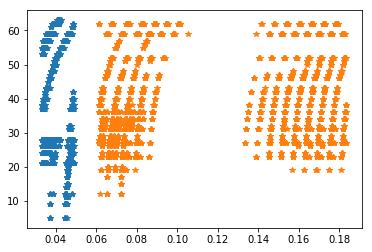

In [3]:
a, b = 3000, 6000
plt.plot(timestamps[ear_id==0][a:b], channel_id[ear_id==0][a:b] % 64, '*')
plt.plot(timestamps[ear_id==1][a:b], channel_id[ear_id==1][a:b] % 64, '*')

In [5]:
dict_c = {}

CH:    0 || MU:  nan || SIGMA:  nan
CH:    1 || MU:  nan || SIGMA:  nan
CH:    2 || MU:  nan || SIGMA:  nan
CH:    3 || MU:  nan || SIGMA:  nan
CH:    4 || MU:  nan || SIGMA:  nan
CH:   10 || MU:  nan || SIGMA:  nan
CH:   12 || MU: -4.06690342061e-05 || SIGMA: 3.85197636206e-05
CH:   14 || MU:  nan || SIGMA:  nan
CH:   15 || MU: 0.000132081695483 || SIGMA: 3.28021305904e-05
CH:   16 || MU:  nan || SIGMA:  nan
CH:   17 || MU: -4.96593384014e-05 || SIGMA: 2.0057126676e-05
CH:   18 || MU:  nan || SIGMA:  nan
CH:   19 || MU: -8.7723339675e-05 || SIGMA: 7.24050842109e-05
CH:   20 || MU: -0.000133297260618 || SIGMA: 3.60376689059e-05
CH:   23 || MU: 0.000118566531455 || SIGMA: 8.1515070633e-05
CH:   24 || MU: 4.04769571105e-06 || SIGMA: 7.32217085897e-05
CH:   25 || MU:  nan || SIGMA:  nan
CH:   26 || MU: 8.8992084784e-05 || SIGMA: 7.57720263209e-05
CH:   27 || MU: 9.99699932436e-06 || SIGMA: 9.68717431533e-05
CH:   28 || MU: 2.92438253382e-05 || SIGMA: 9.52253612923e-05
CH:   31 || MU: -2.3

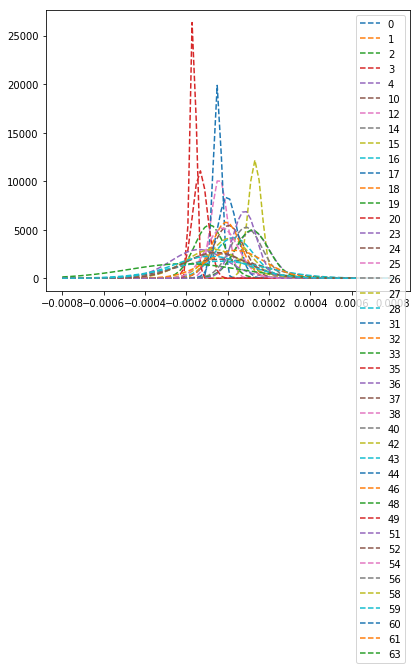

In [6]:
from scipy.stats import norm
fig = plt.figure(figsize=(30,30))
for k, j in enumerate(range(90, 100, 10)):
    ax = fig.add_subplot(5,4, k + 1)
    filename = basedir + 'prior_long_hv_{}'.format(j)
    
    timestamps, addresses = es.loadaerdat(filename + '.aedat')
    timestamps = timestamps[10000:]
    addresses = addresses[10000:]
    timestamps, channel_id, ear_id, neuron_id, filterbank_id = es.decode_ams1c(timestamps, addresses, return_type=False)

    for i in range(0,64):
        w = channel_id == i
        try:
            _itds, _ = itd.get_itds(timestamps[w], ear_id[w], neuron_id[w], save_to_file=None,
                                     verbose=False, max_itd=max_itd)

            mu, std = norm.fit(_itds)
            if not np.isnan(mu):
                dict_c[i] = {'mu': mu, 'std':std}
            x = np.linspace(-max_itd, max_itd, 80)
            p = norm.pdf(x, mu, std)
            ax.plot(x, p, '--', label=i)
            print "CH: {:4} || MU: {:4} || SIGMA: {:4}".format(i, mu, std)
        except:
            pass
#     ax.legend()



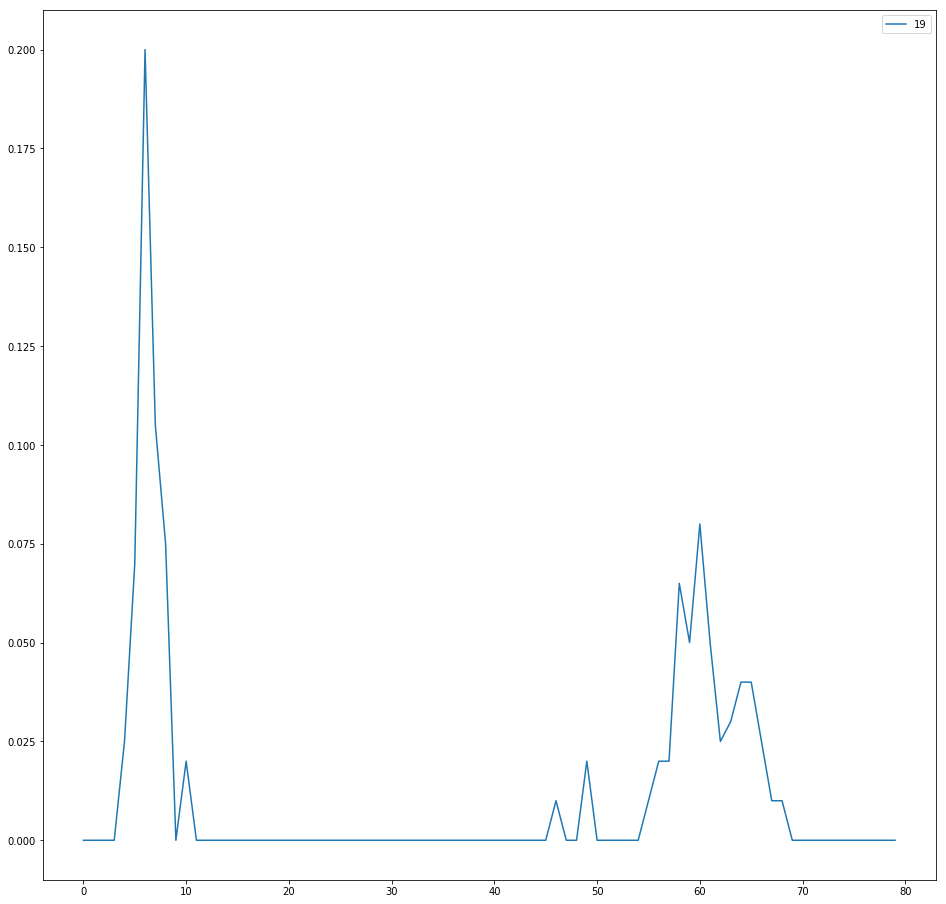

In [23]:
base = '/home/enea/Downloads/aedat/'
filename = base + 'BR30AG705'
    
timestamps, addresses = es.loadaerdat(filename + '.aedat')
timestamps = timestamps[10000:]
addresses = addresses[10000:]
timestamps, channel_id, ear_id, neuron_id, filterbank_id = es.decode_ams1c(timestamps, addresses, return_type=False)

fig = plt.figure(figsize=(16,16))
for i in [19]:
    ax = fig.add_subplot(1,1,1)
    
    w = channel_id == i
    try:
        _itds, _ = itd.get_itds(timestamps[w], ear_id[w], neuron_id[w], save_to_file=None,
                             verbose=False, max_itd=max_itd)
        ax.plot(prob.get_priors(np.array([_itds]))[0], label=i)
    except:
        pass
plt.legend()

In [ ]:
dict_corr = {19: {'mu': -8.7723339675e-05, 'sigma': 7.24050842109e-05}, 
             20: {'mu': -0.000133297260618, 'sigma': 3.60376689059e-05},
             23: {'mu': 0.000118566531455, 'sigma': 8.1515070633e-05},
             24:{'mu': 0, 'sigma': 1}}

In [7]:
dict_c[24] = {'mu': 0, 'sigma': 1}

In [12]:
relevant_channels = np.arange(64)
itd_streams = []
for i in range(0, 190, 10):
    filename = basedir + 'prior_long_hv_{}'.format(i)

    timestamps, addresses = es.loadaerdat(filename + '.aedat')
    timestamps = timestamps[10000:]
    addresses = addresses[10000:]
    timestamps, channel_id, ear_id, neuron_id, filterbank_id = es.decode_ams1c(timestamps, addresses, return_type=False)

    l = len(timestamps)
    perc = int(len(timestamps) * 100 / 100)

    p = np.random.permutation(l)[:perc]

    timestamps = timestamps[p]
    channel_id = channel_id[p]
    ear_id = ear_id[p]
    neuron_id = neuron_id[p]
    _ii = []
    for kk in relevant_channels:
        indices_channels = np.isin(channel_id, np.array([kk]))
        if kk in dict_c:
            try:
                _itds, _ = itd.get_itds(timestamps[indices_channels], ear_id[indices_channels], neuron_id[indices_channels], save_to_file=None,
                                     verbose=False, max_itd=max_itd)
                _mu = dict_c[kk]['mu']
                _corr = (_itds - _mu) / dict_c[kk]['sigma'] * dict_c[24]['sigma']
                _ii.extend(_corr)
            except:
                pass
    itd_streams.append(_ii)

In [11]:
print dict_c.keys()

[12, 15, 17, 19, 20, 23, 24, 26, 27, 28, 31, 32, 33, 35, 36, 37, 38, 40, 42, 43, 46, 48, 51, 52, 59]


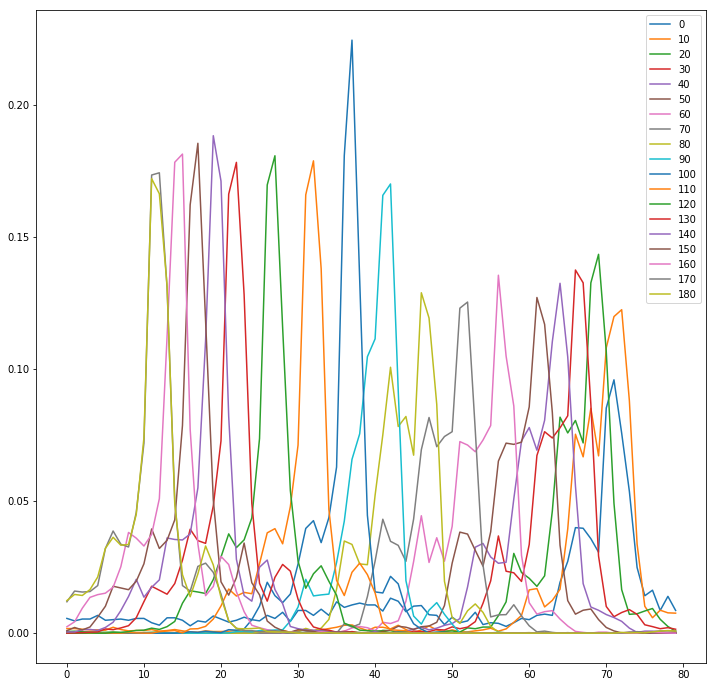

In [13]:
plt.figure(figsize=(12,12))
priors = prob.get_priors(np.array(itd_streams))
for l, j in zip(range(0, 190, 10), priors): 
    plt.plot(j, label=l)
plt.legend()